In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import vstack
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from nltk.corpus import words
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from transformers import BertTokenizer, BertModel
from torch.optim import Adam
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.cuda.amp import GradScaler, autocast
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\panha\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## BoW and TF-IDF with Logistic Regression

In [ ]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, weight_decay=0.01):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def sparse_collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs = torch.FloatTensor(vstack(inputs).toarray())
    labels = torch.FloatTensor(labels).unsqueeze(1)
    return inputs, labels

def train_and_evaluate(X, y, model, epochs=10, batch_size=64, learning_rate=0.01, patience=5):
    dataset = list(zip([X[i] for i in range(X.shape[0])], y))
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=sparse_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=sparse_collate_fn)
    
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader)

        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

    # Evaluation metrics
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            y_scores.extend(outputs.numpy().flatten())
            predictions = (outputs > 0.5).float()
            y_pred.extend(predictions.numpy().flatten())
            y_true.extend(labels.numpy().flatten())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=['Negative', 'Positive'])
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

    return model

In [ ]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    BoW_vectorizer = CountVectorizer(max_features=30000, min_df=5, max_df=0.90)
    X_bow = BoW_vectorizer.fit_transform(df['processed_text_str'])
    y = df['target'].values

    Tfidf_vectorizer = TfidfVectorizer(max_features=30000, min_df=5, max_df=0.90)
    X_tfidf = Tfidf_vectorizer.fit_transform(df['processed_text_str'])

    model_bow = LogisticRegressionModel(X_bow.shape[1])
    trained_model_bow = train_and_evaluate(X_bow, y, model_bow, epochs=10, batch_size=64, learning_rate=0.05)
    torch.save(trained_model_bow.state_dict(), 'trained_model_bow.pth')

    model_tfidf = LogisticRegressionModel(X_tfidf.shape[1])
    trained_model_tfidf = train_and_evaluate(X_tfidf, y, model_tfidf, epochs=10, batch_size=64, learning_rate=0.05)
    torch.save(trained_model_tfidf.state_dict(), 'trained_model_tfidf.pth')

# BoW and TF-IDF with SVM Model

In [5]:
class SparseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx].toarray().squeeze(), self.y.iloc[idx]

class RBFLayer(nn.Module):
    def __init__(self, centers, gamma=1.0):
        super(RBFLayer, self).__init__()
        self.centers = nn.Parameter(centers)
        self.gamma = nn.Parameter(torch.tensor(gamma))

    def forward(self, x):
        size = (x.size(0), self.centers.size(0))
        x_expanded = x.unsqueeze(1).expand(size + (x.size(-1),))
        c_expanded = self.centers.unsqueeze(0).expand(size + (x.size(-1),))
        distances = torch.norm(x_expanded - c_expanded, dim=2)
        return torch.exp(-self.gamma * distances**2)

class SVMRBFModel(nn.Module):
    def __init__(self, num_centers, input_dim, gamma='scale'):
        super(SVMRBFModel, self).__init__()
        centers = torch.randn(num_centers, input_dim)
        self.rbf_layer = RBFLayer(centers, gamma=1.0 if gamma == 'scale' else gamma)
        self.fc = nn.Linear(num_centers, 1)

    def forward(self, x):
        x = self.rbf_layer(x)
        return self.fc(x)


def train_and_evaluate(model, train_loader, test_loader, epochs=10, learning_rate=0.01, device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.float().to(device)
                outputs = model(inputs)
                predicted = torch.sigmoid(outputs).round()
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.cpu().numpy().flatten())

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        print(f'Epoch {epoch+1}, Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

        cm = confusion_matrix(y_true, y_pred)
        plt.figure()
        plot_confusion_matrix(cm, classes=['Negative', 'Positive'])
        plt.show()

def main():
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    # Initialize both vectorizers
    vectorizer_bow = CountVectorizer(max_features=30000, min_df=5, max_df=0.90)
    vectorizer_tfidf = TfidfVectorizer(max_features=30000, min_df=5, max_df=0.90)

    # Transform the text using both vectorizers
    X_bow = vectorizer_bow.fit_transform(df['processed_text_str'])
    X_tfidf = vectorizer_tfidf.fit_transform(df['processed_text_str'])

    # Split the data for BoW
    X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, df['target'], test_size=0.2, random_state=42)
    train_dataset_bow = SparseDataset(X_train_bow, y_train)
    train_loader_bow = DataLoader(train_dataset_bow, batch_size=32, shuffle=True)
    test_dataset_bow = SparseDataset(X_test_bow, y_test)
    test_loader_bow = DataLoader(test_dataset_bow, batch_size=32, shuffle=False)

    # Split the data for TF-IDF
    X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, df['target'], test_size=0.2, random_state=42)
    train_dataset_tfidf = SparseDataset(X_train_tfidf, y_train)
    train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=32, shuffle=True)
    test_dataset_tfidf = SparseDataset(X_test_tfidf, y_test)
    test_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=32, shuffle=False)

    # Train and evaluate with BoW
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_bow = SVMRBFModel(num_centers=500, input_dim=X_train_bow.shape[1]).to(device)
    print("Training with BoW...")
    train_and_evaluate(model_bow, train_loader_bow, test_loader_bow, epochs=10, learning_rate=0.005, device=device)
    torch.save(model_bow.state_dict(), "Trained Model/svm_rbf_model_bow.pth")
    # Train and evaluate with TF-IDF
    model_tfidf = SVMRBFModel(num_centers=500, input_dim=X_train_tfidf.shape[1]).to(device)
    print("Training with TF-IDF...")
    train_and_evaluate(model_tfidf, train_loader_tfidf, test_loader_tfidf, epochs=10, learning_rate=0.005, device=device)
    torch.save(model_tfidf.state_dict(), "Trained Model/svm_rbf_model_tfidf.pth")

In [6]:
if __name__ == '__main__':
    main()

Training with BoW...


KeyboardInterrupt: 

# GloVe Embeddings with LSTM Model

Starting training the LSTM Model...
Epoch 1, Validation Loss: 0.4550
Epoch 2, Validation Loss: 0.4425
Epoch 3, Validation Loss: 0.4378
Epoch 4, Validation Loss: 0.4363
Epoch 5, Validation Loss: 0.4360
Training complete. Loading the best model...


C:\Users\panha\AppData\Local\Temp\ipykernel_1000\3849993699.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Trained Model/LSTM_GloVe_m

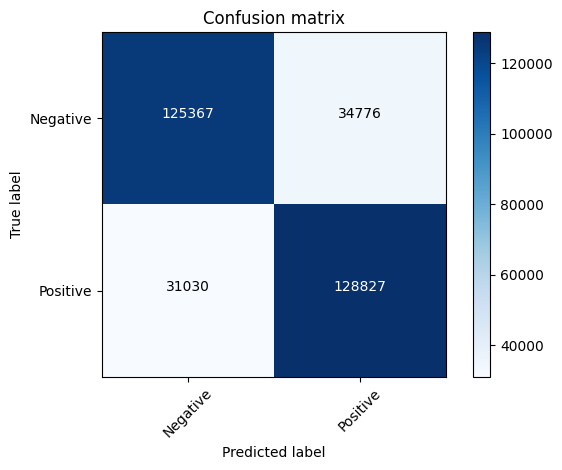

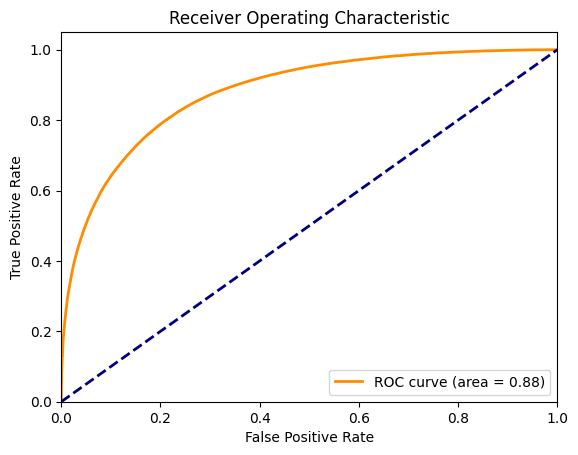

Accuracy: 0.79, Precision: 0.79, Recall: 0.81, F1 Score: 0.80


In [2]:
def load_glove_embeddings(path, expected_dim):
    english_words = set(words.words())
    embedding_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in english_words:
                vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
                if vector.size(0) == expected_dim:
                    embedding_index[word] = vector
                else:
                    print(f"Skipped word '{word}' due to unexpected dimension size: {vector.size(0)}")
    return embedding_index

def create_embedding_matrix(word_index, embeddings_index, dimension):
    embedding_matrix = torch.zeros(len(word_index) + 1, dimension)
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

class AttentionLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, dropout=0.5):
        super(AttentionLSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embedding_matrix.size(1), hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        weights = torch.softmax(self.attention(outputs), dim=1)
        context = (weights * outputs).sum(dim=1)
        return self.sigmoid(self.fc(context))

def collate_fn(batch):
    inputs, labels = zip(*batch)
    lengths = [len(x) for x in inputs]
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.FloatTensor(labels).unsqueeze(1)
    return padded_inputs, labels, torch.LongTensor(lengths)

def train_and_evaluate(X, y, model, epochs, batch_size, learning_rate, patience, device):
    model.to(device)
    dataset = list(zip(X, y))
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting training the LSTM Model...")
    for epoch in range(epochs):
        model.train()
        for inputs, labels, lengths in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths.cpu())  # Ensure lengths stay on CPU
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels, lengths in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs, lengths.cpu())  # Ensure lengths stay on CPU
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'Trained Model/LSTM_GloVe_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break
        scheduler.step()

    print("Training complete. Loading the best model...")
    model.load_state_dict(torch.load('Trained Model/LSTM_GloVe_model.pth'))

    # Evaluation metrics
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for inputs, labels, lengths in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, lengths.cpu())  # Ensure lengths stay on CPU
            y_scores.extend(outputs.cpu().numpy().flatten())
            predictions = (outputs > 0.5).float()
            y_pred.extend(predictions.cpu().numpy().flatten())
            y_true.extend(labels.cpu().numpy().flatten())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=['Negative', 'Positive'])
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')
    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'  # 'd' for integer format
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    tokenized_data = df['processed_text_str'].apply(word_tokenize)
    glove_path = 'GloVe/glove.twitter.27B.200d.txt'
    glove_embeddings = load_glove_embeddings(glove_path, 200)
    vocab = {word: idx + 1 for idx, word in enumerate(glove_embeddings.keys())}
    tokenized_sequences = [
        torch.LongTensor([vocab.get(word, 0) for word in sentence]) for sentence in tokenized_data
    ]
    targets = torch.FloatTensor(df['target'].values)
    embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, 200)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AttentionLSTMModel(embedding_matrix, hidden_dim=128, num_layers=2, dropout=0.5)
    trained_model = train_and_evaluate(tokenized_sequences, targets, model, epochs=5, batch_size=64, learning_rate=1e-4, patience=5, device=device)

# GloVe Embeddings with BiLSTM Model

In [5]:
def load_glove_embeddings(path, expected_dim):
    english_words = set(words.words())
    embedding_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in english_words:
                vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
                if vector.size(0) == expected_dim:
                    embedding_index[word] = vector
                else:
                    print(f"Skipped word '{word}' due to unexpected dimension size: {vector.size(0)}")
    return embedding_index

def create_embedding_matrix(word_index, embeddings_index, dimension):
    embedding_matrix = torch.zeros(len(word_index) + 1, dimension)
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

class AttentionBiLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, dropout=0.5):
        super(AttentionBiLSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.bilstm = nn.LSTM(embedding_matrix.size(1), hidden_dim, num_layers,
                              batch_first=True, dropout=dropout, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        outputs, _ = self.bilstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        weights = torch.softmax(self.attention(outputs), dim=1)
        context = (weights * outputs).sum(dim=1)
        return self.sigmoid(self.fc(context))

def collate_fn(batch):
    inputs, labels = zip(*batch)
    lengths = [len(x) for x in inputs]
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.FloatTensor(labels).unsqueeze(1)
    return padded_inputs, labels, torch.LongTensor(lengths)

def train_and_evaluate(X, y, model, epochs, batch_size, learning_rate, patience, device):
    model.to(device)
    dataset = list(zip(X, y))
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting training the BiLSTM Model...")
    for epoch in range(epochs):
        model.train()
        for inputs, labels, lengths in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths.cpu())  # Ensure lengths stay on CPU
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels, lengths in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs, lengths.cpu())  # Ensure lengths stay on CPU
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'Trained Model/BiLSTM_GloVe_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break
        scheduler.step()

    print("Training complete. Loading the best model...")
    model.load_state_dict(torch.load('Trained Model/BiLSTM_GloVe_model.pth'))

    # Evaluation metrics
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for inputs, labels, lengths in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, lengths.cpu())  # Ensure lengths stay on CPU
            y_scores.extend(outputs.cpu().numpy().flatten())
            predictions = (outputs > 0.5).float()
            y_pred.extend(predictions.cpu().numpy().flatten())
            y_true.extend(labels.cpu().numpy().flatten())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=['Negative', 'Positive'])
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')
    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'  # 'd' for integer format
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Starting training the BiLSTM Model...
Epoch 1, Validation Loss: 0.4550
Epoch 2, Validation Loss: 0.4463
Epoch 3, Validation Loss: 0.4402
Epoch 4, Validation Loss: 0.4380
Epoch 5, Validation Loss: 0.4374
Training complete. Loading the best model...


C:\Users\panha\AppData\Local\Temp\ipykernel_13664\2836637614.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Trained Model/BiLSTM_GloV

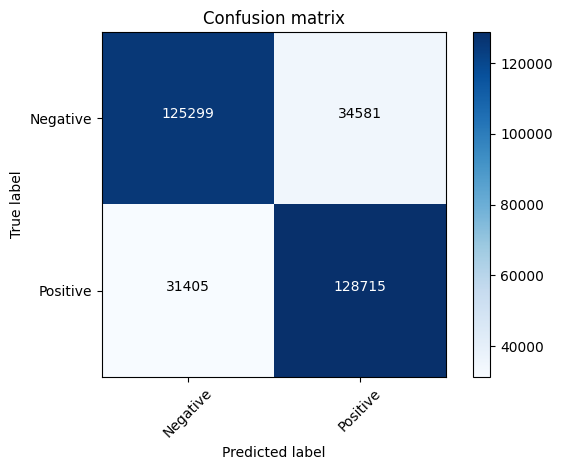

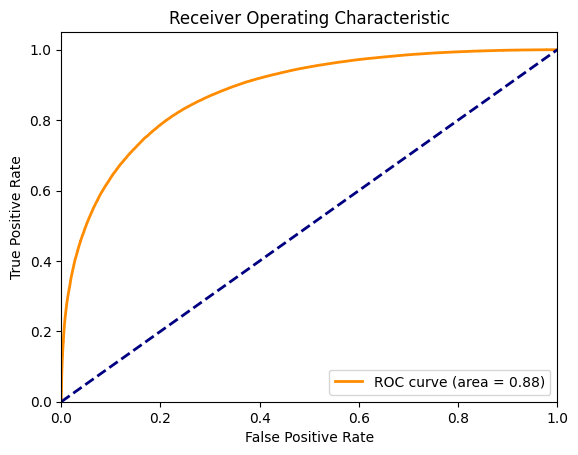

Accuracy: 0.79, Precision: 0.79, Recall: 0.80, F1 Score: 0.80


In [6]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    tokenized_data = df['processed_text_str'].apply(word_tokenize)
    glove_path = 'GloVe/glove.twitter.27B.200d.txt'
    glove_embeddings = load_glove_embeddings(glove_path, 200)
    vocab = {word: idx + 1 for idx, word in enumerate(glove_embeddings.keys())}
    tokenized_sequences = [
        torch.LongTensor([vocab.get(word, 0) for word in sentence]) for sentence in tokenized_data
    ]
    targets = torch.FloatTensor(df['target'].values)
    embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, 200)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AttentionBiLSTMModel(embedding_matrix, hidden_dim=128, num_layers=2, dropout=0.5)
    trained_model = train_and_evaluate(tokenized_sequences, targets, model, epochs=5, batch_size=64, learning_rate=1e-4, patience=5, device=device)

Epoch 1, Validation Loss: 0.4550

# Hybird Model(CNNs and BiLSTM) with GloVe

In [7]:
def load_glove_embeddings(path, expected_dim):
    english_words = set(words.words())
    embedding_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in english_words:
                vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
                if vector.size(0) == expected_dim:
                    embedding_index[word] = vector
                else:
                    print(f"Skipped word '{word}' due to unexpected dimension size: {vector.size(0)}")
    return embedding_index

def create_embedding_matrix(word_index, embeddings_index, dimension):
    embedding_matrix = torch.zeros(len(word_index) + 1, dimension)
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

class HybridCNNBiLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_layers, num_filters, kernel_sizes, dropout=0.5):
        super(HybridCNNBiLSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_matrix.size(1),
                      out_channels=num_filters,
                      kernel_size=k) for k in kernel_sizes
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.bilstm = nn.LSTM(num_filters * len(kernel_sizes), hidden_dim,
                              num_layers=num_layers, batch_first=True,
                              dropout=dropout, bidirectional=True)
        
        self.fc = nn.Linear(hidden_dim * 2, 1)  # Bi-directional outputs * 2
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)  # [batch_size, seq_length, embed_dim]
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embed_dim, seq_length] for Conv1d
        
        convoluted = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(c, dim=2)[0] for c in convoluted]
        concatenated = torch.cat(pooled, dim=1)
        concatenated = self.dropout(concatenated)
        
        # LSTM part
        outputs, _ = self.bilstm(concatenated.unsqueeze(1))  # Add a channel dimension
        outputs = outputs[:, -1, :]  # Take the outputs from the last time step
        output = self.fc(outputs)
        return self.sigmoid(output)

def collate_fn(batch):
    inputs, labels = zip(*batch)
    lengths = [len(x) for x in inputs]
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.FloatTensor(labels).unsqueeze(1)
    return padded_inputs, labels, torch.LongTensor(lengths)

def train_and_evaluate(X, y, model, epochs, batch_size, learning_rate, patience, device):
    model.to(device)
    dataset = list(zip(X, y))
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting training the Hybrid CNN-BiLSTM Model...")
    for epoch in range(epochs):
        model.train()
        for inputs, labels, lengths in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths.cpu())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels, lengths in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs, lengths.cpu())
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'Trained Model/Hybrid_CNN_BiLSTM_GloVe_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break
        scheduler.step()

    print("Training complete. Loading the best model...")
    model.load_state_dict(torch.load('Trained Model/Hybrid_CNN_BiLSTM_GloVe_model.pth'))

    # Evaluation metrics
    y_true = []
    y_pred = []
    y_scores = []
    with torch.no_grad():
        for inputs, labels, lengths in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, lengths.cpu())
            y_scores.extend(outputs.cpu().numpy().flatten())
            predictions = (outputs > 0.5).float()
            y_pred.extend(predictions.cpu().numpy().flatten())
            y_true.extend(labels.cpu().numpy().flatten())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=['Negative', 'Positive'])
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

: 

In [ ]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    tokenized_data = df['processed_text_str'].apply(word_tokenize)
    glove_path = 'GloVe/glove.twitter.27B.200d.txt'
    glove_embeddings = load_glove_embeddings(glove_path, 200)
    vocab = {word: idx + 1 for idx, word in enumerate(glove_embeddings.keys())}
    tokenized_sequences = [
        torch.LongTensor([vocab.get(word, 0) for word in sentence]) for sentence in tokenized_data
    ]
    targets = torch.FloatTensor(df['target'].values)
    embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, 200)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = HybridCNNBiLSTMModel(embedding_matrix, hidden_dim=128, num_layers=2, num_filters=100, kernel_sizes=[3, 4, 5], dropout=0.5)
    trained_model = train_and_evaluate(tokenized_sequences, targets, model, epochs=5, batch_size=32, learning_rate=1e-4, patience=3, device=device)

Starting training the Hybrid CNN-BiLSTM Model...
Epoch 1, Validation Loss: 0.4542
Epoch 2, Validation Loss: 0.4472
Epoch 3, Validation Loss: 0.4435
Epoch 4, Validation Loss: 0.4416
Epoch 5, Validation Loss: 0.4416


# Hybird Model(LSTM + Transformer) with GloVe Embeddings

In [3]:
def load_glove_embeddings(path, expected_dim):
    english_words = set(words.words())
    embedding_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in english_words:
                vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
                if vector.size(0) == expected_dim:
                    embedding_index[word] = vector
                else:
                    print(f"Skipped word '{word}' due to unexpected dimension size: {vector.size(0)}")
    return embedding_index

# Create Embedding Matrix
def create_embedding_matrix(word_index, embeddings_index, dimension):
    embedding_matrix = torch.zeros(len(word_index) + 1, dimension)
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Transformer + LSTM Model
class TransformerLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, lstm_layers, transformer_layers=1, dropout=0.5):
        super(TransformerLSTMModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embedding_matrix.size(1), hidden_dim, lstm_layers, batch_first=True)
        transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=transformer_layers)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        transformer_out = self.transformer_encoder(lstm_out)
        pooled = torch.mean(transformer_out, dim=1)
        return self.sigmoid(self.fc(pooled))

# Data Collation Function
def collate_fn(batch):
    inputs, labels = zip(*batch)
    lengths = [len(x) for x in inputs]
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.FloatTensor(labels).unsqueeze(1)
    return padded_inputs, labels, torch.LongTensor(lengths)

# Training and Evaluation Function
def train_and_evaluate(X, y, model, epochs, batch_size, learning_rate, patience, device):
    model.to(device)
    dataset = list(zip(X, y))
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting training the Transformer + LSTM Model...")
    for epoch in range(epochs):
        model.train()
        for inputs, labels, lengths in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths.cpu())  # Ensure lengths stay on CPU
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels, lengths in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs, lengths.cpu())  # Ensure lengths stay on CPU
                val_loss += criterion(outputs, labels).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'Trained Model/Transformer_LSTM_GloVe_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping!")
            break
        scheduler.step()

    print("Training complete. Loading the best model...")
    model.load_state_dict(torch.load('Trained Model/Transformer_LSTM_GloVe_model.pth'))

    # Evaluation metrics
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for inputs, labels, lengths in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, lengths.cpu())  # Ensure lengths stay on CPU
            y_scores.extend(outputs.cpu().numpy().flatten())
            predictions = (outputs > 0.5).float()
            y_pred.extend(predictions.cpu().numpy().flatten())
            y_true.extend(labels.cpu().numpy().flatten())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=['Negative', 'Positive'])
    plt.show()

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')
    return model

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Starting training the Transformer + LSTM Model...


c:\Users\panha\anaconda3\envs\cuda_gpu\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1, Validation Loss: 0.4602
Epoch 2, Validation Loss: 0.4454
Epoch 3, Validation Loss: 0.4415
Epoch 4, Validation Loss: 0.4374
Epoch 5, Validation Loss: 0.4369
Training complete. Loading the best model...


C:\Users\panha\AppData\Local\Temp\ipykernel_1000\2460475044.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Trained Model/Transformer

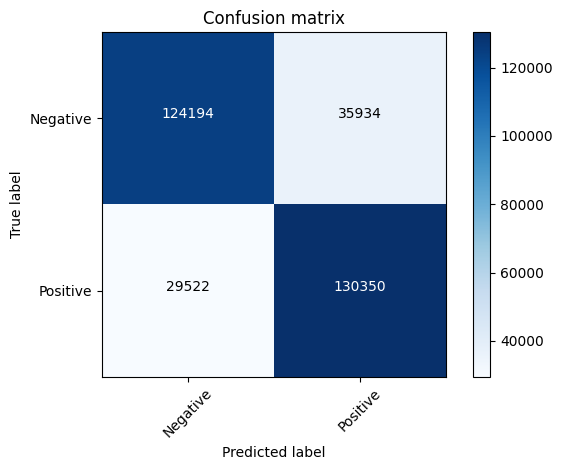

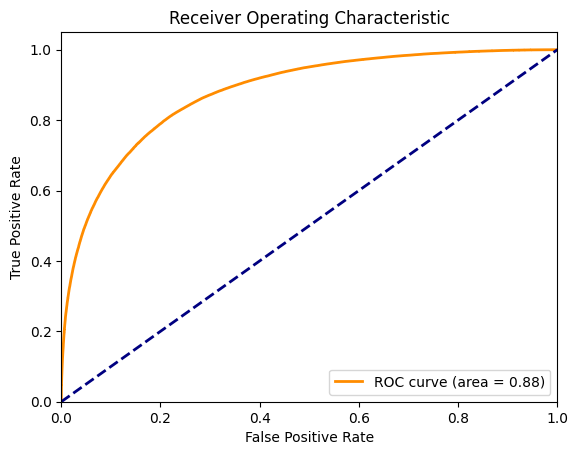

Accuracy: 0.80, Precision: 0.78, Recall: 0.82, F1 Score: 0.80


In [4]:
if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)

    tokenized_data = df['processed_text_str'].apply(word_tokenize)
    glove_path = 'GloVe/glove.twitter.27B.200d.txt'
    glove_embeddings = load_glove_embeddings(glove_path, 200)
    vocab = {word: idx + 1 for idx, word in enumerate(glove_embeddings.keys())}
    tokenized_sequences = [
        torch.LongTensor([vocab.get(word, 0) for word in sentence]) for sentence in tokenized_data
    ]
    targets = torch.FloatTensor(df['target'].values)
    embedding_matrix = create_embedding_matrix(vocab, glove_embeddings, 200)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerLSTMModel(embedding_matrix, hidden_dim=128, lstm_layers=2, transformer_layers=1, dropout=0.5)
    trained_model = train_and_evaluate(tokenized_sequences, targets, model, epochs=5, batch_size=64, learning_rate=1e-4, patience=5, device=device)

## Bert Model using Bert Pre-trained Tokenizer

In [12]:
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    tokenized = tokenizer(
        df['text'].tolist(), 
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    dataset = TextDataset(
        input_ids=tokenized['input_ids'],
        attention_masks=tokenized['attention_mask'],
        labels=torch.tensor(df['target'].values)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_classes)
    
    def forward(self, input_ids, attention_mask, labels=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        x = self.dropout(pooled_output)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def evaluate_model(model, data_loader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = torch.nn.functional.softmax(logits, dim=1)

            y_probs.extend(probabilities[:, 1].cpu().numpy())
            y_pred.extend(logits.argmax(dim=1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, roc_auc, y_true, y_pred, y_probs

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs):
    model.to(device)
    scaler = GradScaler()
    best_accuracy = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for d in train_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(input_ids, attention_mask)
                loss = nn.CrossEntropyLoss()(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        val_accuracy, val_precision, val_recall, val_f1, val_roc_auc, _, _, _ = evaluate_model(model, val_loader, device)
        scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'Trained Model/enhanced_BERT_model2.pth')
            print("Model saved!")

    print("Training complete!")

In [ ]:
torch.backends.cudnn.benchmark = True

if __name__ == '__main__':
    df = pd.read_csv('dataset_tweets_preprocessed2.csv')
    df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
    df['processed_text_str'] = df['processed_text_str'].astype(str)
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    MAX_LEN = 128
    BATCH_SIZE = 64
    EPOCHS = 6
    LEARNING_RATE = 2e-5

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
    val_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SentimentClassifier(n_classes=2).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    train_model(model, train_loader, val_loader, optimizer, scheduler, device, EPOCHS)

    accuracy, precision, recall, f1, roc_auc, y_true, y_pred, y_probs = evaluate_model(model, val_loader, device)
    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    plot_roc_curve(y_true, y_probs)
    plot_confusion_matrix(y_true, y_pred)